# ExprOptimization.jl

ExprOptimization.jl is a Julia package for optimizing Julia expressions.  The package implements algorithms to optimize expression trees derived from a grammar to optimize a user-defined objective function.  The package depends on ExprRules.jl.

## Installation

To install the package:

    Pkg.add("ExprOptimization")

## Usage

To start using the package:

In [1]:
using ExprOptimization

## Example -- Symbolic Regression

We consider the example of finding an algebraic expression that approximates a given function.

First, we define a grammar:

In [2]:
grammar = @grammar begin
    Real = x
    Real = Real * Real
    Real = Real + Real
    Real = Real - Real
    Real = |(1.0:5.0)
end

1: Real = x
2: Real = Real * Real
3: Real = Real + Real
4: Real = Real - Real
5: Real = 1.0
6: Real = 2.0
7: Real = 3.0
8: Real = 4.0
9: Real = 5.0


Next, we define the ground truth expression and loss function by overloading the `loss` function in ExprOptimization.  The loss function returns the real-valued loss of a given expression tree.  The loss is minimized.

In [3]:
ground_truth(x) = x*x + 2x + 1
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    los = 0.0
    global x
    for x = -5.0:1.0:5.0
        los += abs2(eval(ex) - ground_truth(x))
    end
    los
end

loss (generic function with 1 method)

Once these are defined, we can use any of the implemented algorithms to perform the optimization.

### Monte Carlo

Monte Carlo (MC) draws a number of random expression trees from the grammar and returns the one with the best loss.

In [4]:
?MonteCarlo

search: MonteCarlo MonteCarlos



```
MonteCarlo
```

Monte Carlo.

# Arguments:

  * `num_samples::Int`: number of samples
  * `max_depth::Int`: maximum depth of derivation tree


In [5]:
srand(10)
p = MonteCarlo(20000, 6)
results_mc = optimize(p, grammar, :Real, loss)
(results_mc.expr, results_mc.loss)

(:(x * (2.0 + ((5.0 - 5.0) + (x + (3.0 - 3.0)))) + (3.0 - 1.0 * 2.0)), 0.0)

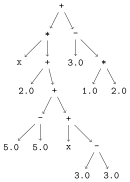

In [6]:
display(results_mc.tree, grammar)

## Genetic Programming

Genetic Programming (GP) is an evolutionary algorithm for trees.

See: Koza, "Genetic Programming: On the Programming of Computers by Means of Natural Selection", MIT Press, 1992.

In [7]:
?GeneticProgram

search: GeneticProgram GeneticPrograms



```
GeneticProgram
```

Genetic Programming.

# Arguments

  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `p_reproduction::Float64`: probability of reproduction operator
  * `p_crossover::Float64`: probability of crossover operator
  * `p_mutation::Float64`: probability of mutation operator
  * `init_method::InitializationMethod`: initialization method
  * `select_method::SelectionMethod`: selection method


In [8]:
srand(1)
p = GeneticProgram(1000,20,6,0.3,0.3,0.4)
results_gp = optimize(p, grammar, :Real, loss)
(results_gp.expr, results_gp.loss)

(:(x * x + ((x + 1.0) + x)), 0.0)

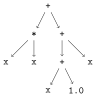

In [9]:
display(results_gp.tree, grammar)

## Grammatical Evolution

Grammatical Evolution (GE) is an evolutionary algorithm based on sequentializing the decisions in the derivation tree (e.g., using depth-first traversal order).  Optimization is performed over integer arrays using genetic algorithms.

See: C. Ryan, J.J. Collins, M. O'Neil, "Grammatical Evolution: Evolving Programs for an Arbitrary Language", in European Conference on Genetic Programming, Springer, 1998, pp. 83-96.

In [10]:
?GrammaticalEvolution

search: GrammaticalEvolution GrammaticalEvolutions



```
GrammaticalEvolution
```

Grammatical Evolution.

# Arguments

  * `grammar::Grammar`: grammar
  * `typ::Symbol`: start symbol
  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `init_gene_length::Int`: initial length of genotype integer array
  * `max_gene_length::Int`: maximum length of genotype integer array
  * `max_depth::Int`: maximum depth of derivation tree
  * `p_reproduction::Float64`: probability of reproduction operator
  * `p_crossover::Float64`: probability of crossover operator
  * `p_mutation::Float64`: probability of mutation operator
  * `select_method::SelectionMethod`: selection method (default: tournament selection)
  * `mutate_method::InitializationMethod`: mutation method (default: multi-mutate)


In [11]:
srand(0)
p = GrammaticalEvolution(grammar,:Real,1000,20,10,10,6,0.2,0.4,0.4; select_method=GrammaticalEvolutions.TruncationSelection(300))
results_ge = optimize(p, grammar, :Real, loss)
(results_ge.expr, results_ge.loss)

(:(((2.0 + x) - 1.0) * (1.0 + x)), 0.0)

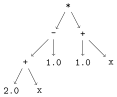

In [12]:
display(results_ge.tree, grammar)

## Cross-Entropy Method

The Cross-Entropy (CE) Method is a population-based optimization algorithm based on repeatedly estimating the probability distribution of good solutions.  This implementation uses a probabilistic grammar to represent the distributions.

See: Rubinstein, "Optimization of Computer Simulation Models with Rare Events", European Journal of Operations Research, 99, 89-112, 1197

In [13]:
?CrossEntropy

search: CrossEntropy CrossEntropys



```
CrossEntropy
```

Cross Entropy method.

# Arguments

  * `pop_size::Int`: population size
  * `iiterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `top_k::Int`: top k elite samples used in selection
  * `p_init::Float64`: initial value when fitting MLE
  * `init_method::InitializationMethod`: Initialization method


In [14]:
srand(1)
p = CrossEntropy(1000,20,6,500)
results_ce = optimize(p, grammar, :Real, loss)
(results_ce.expr, results_ce.loss)

(:(x * (2.0 + x) + 1.0), 0.0)

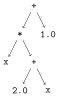

In [15]:
display(results_ce.tree, grammar)

## PIPE

Probabilistic Incremental Program Evolution (PIPE) is an expression tree optimization algorithm based on the probabilistic prototype tree (PPT) model.

See: Salustowicz and Schmidhuber, "Probabilistic Incremental Program Evolution", Evolutionary Computation, vol. 5, no. 2, pp. 123-141, 1997.

In [16]:
?PIPE

search: PIPE PIPEs Pipe pipeline PipeBuffer Base64EncodePipe Base64DecodePipe



```
PIPE
```

Probabilistic Incremental Program Evolution. Example parameters from paper are indicated in parentheses)

# Arguments:

  * `ppt_params::PPT`: parameters for PPT  (e.g., [0.8, 0.2])
  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `p_elitist::Float64`: elitist update probability (e.g., 0.2)
  * `c::Float64`: learning rate multiplier (e.g., 0.1)
  * `α::Float64`: learning rate (e.g., 0.05)
  * `ϵ::Float64`: fitness constant (e.g., 1)
  * `p_mutation::Float64`: mutation probability (e.g., 0.2)
  * `β::Float64`: mutation rate (e.g., 0.6)
  * `p_threshold::Float64`: prune threshold (e.g., 0.999)
  * `max_depth::Int`: maximum depth of derivation tree


In [17]:
srand(3)
p = PIPE(PPT(0.8),1000,20,0.2,0.1,0.05,1,0.2,0.6,0.999,6)
results_pipe = optimize(p, grammar, :Real, loss)
(results_pipe.expr, results_pipe.loss)

(:(x * (1.0x - ((5.0 - 1.0) - 5.0)) + (1.0 + x)), 0.0)

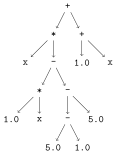

In [18]:
display(results_pipe.tree, grammar)